In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt

In [2]:
EXECUTABLES_DIR = '../bin'
ALGORITHM_FILENAME = 'cvrp_cws'
INSTANCE_FILENAME = 'A-n33-k5'
INSTANCE_FILEPATH = 'instancias/%s.txt' % INSTANCE_FILENAME


In [3]:
def ruta_instancia(instancia):
    return INSTANCE_FILEPATH

# Creo el archivo levantando los parámetros de la instancia que me son relevantes
def crear_instancia(instancia):
    file_name = 'instancias/corridas/%s.txt' % (instancia)
    output_file = open(file_name, 'w')
    
    input_file = open(ruta_instancia(instancia), 'r')
    
    lines = input_file.readlines()
    # number of vertex in graph
    v_size = int(lines[3].split()[2])
    output_file.write(str(v_size)+ '\n')
    # capacity of each truck
    output_file.write(lines[5].split()[2] + '\n')
    # cordenates of vertex in euclidean space
    for index in range(7, 7+v_size):
        output_file.write(lines[index])
    # objective capacity of vertex
    for index in range(7+v_size+1, 7+v_size+1+v_size):
        output_file.write(lines[index])

    input_file.close()
    output_file.close()
    return file_name

In [4]:
# Creo un DataFrame con la instancia pedida
def cargar_informacion(nombre_instancia):
    matrix_data = []
    archivo_instancia = open(nombre_instancia, 'rb')
    
    lines = archivo_instancia.readlines()
    # number of vertex in graph
    v_size = int(lines[0])
    # camiones
    truck_size = int(lines[1])
    # cordenates of vertex in euclidean space
    for index in range(2, 2+v_size):
        line = lines[index].split()
        matrix_data.append( [int(line[0]), int(line[1]) ,int(line[2]) ,0, truck_size, v_size])
    # objective capacity of vertex
    for index in range(2+v_size, 2+v_size+v_size):
        line = lines[index].split()
        vertex = int(line[0])
        objective = int(line[1])
        matrix_data[vertex-1][3] = objective
        
    archivo_instancia.close()
    return pd.DataFrame(matrix_data, columns=['numero_punto','x', 'y','objetivo','truck_amount','vertex_amount'])

In [5]:
# Corro el $algoritmo (ejecutable) para el input del $archivo
def correr_instancia(dataframe, algoritmo,file_name):
    input_data = str(dataframe.loc[dataframe.numero_punto == 1, 'vertex_amount'].values[0]) + '\n' 
    input_data = input_data + str(dataframe.loc[dataframe.numero_punto == 1, 'truck_amount'].values[0]) + '\n' 
    input_data = input_data + dataframe[['x', 'y','objetivo']].to_csv(header=False,index=False,sep=' ',line_terminator='\n')
    
    output_file = open(file_name, 'w')
    output_file.write(input_data)
    output_file.close()
    
    try:
        result = subprocess.run(["{0}/{1}".format(EXECUTABLES_DIR, algoritmo)], stdout=subprocess.PIPE, input=str.encode(input_data))
    except subprocess.CalledProcessError as e:
        Raise ("Algorithm ERROR {}".format(e.output))
    results = result.stdout.decode("utf-8").split('\n')
    results.pop(len(results) -1)
    return results

def lista_de(lista,tipo):
    return list(map(lambda valor : tipo(valor),lista))

In [6]:
def parsear_y_guardar(dataframe, listas):
    camiones = int(listas[0])
    dataframe['result'] = int(listas[camiones+1])
    dataframe['caminos'] = 0
   
    # Elijo un cluster para cada camimno
    indice_grupo = 1
    for index in range(camiones):
        caminos = map(lambda x : int(x), listas[indice_grupo].split())
        for parada in caminos:
            dataframe.loc[dataframe.numero_punto == parada, 'caminos'] = indice_grupo
        indice_grupo = indice_grupo + 1
          
#     El primero está en todos los caminos así que mejor lo saco de todos.
    dataframe.loc[dataframe.numero_punto == 1, 'caminos'] = 0
    
    
    return dataframe
    

In [24]:
# Englobo todas las funciones y devuelvo un DataFrame con la instancia y los clusters calculados
def calcular_y_graficar(instancia, ejecutable):
    file_name = crear_instancia(instancia)
    dataframe = cargar_informacion(file_name)
    results = correr_instancia(dataframe, ejecutable, file_name)
    dataframe = parsear_y_guardar(dataframe, results)
    return dataframe, results

## Correr una instancia con parámetros

In [133]:
dataframe, results = calcular_y_graficar(INSTANCE_FILENAME, ALGORITHM_FILENAME)
dataframe

,numero_punto,x,y,objetivo,truck_amount,vertex_amount,result,caminos
0,1,42,68,0,100,33,711,0
1,2,77,97,5,100,33,711,3
2,3,28,64,23,100,33,711,4
3,4,77,39,14,100,33,711,2
4,5,32,33,13,100,33,711,1
5,6,32,8,8,100,33,711,5
6,7,42,92,18,100,33,711,3
7,8,8,3,19,100,33,711,1
8,9,7,14,10,100,33,711,1
9,10,82,17,18,100,33,711,2


## Graficar la instancia anterior

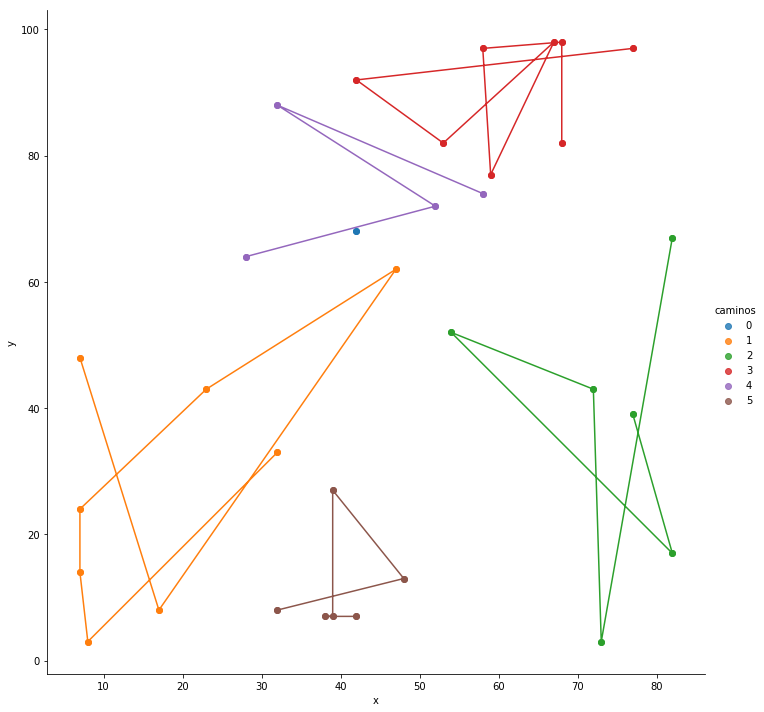

In [128]:
sns.lmplot(data=dataframe,x='x',y='y',hue='caminos',fit_reg=False, legend=True, legend_out=True,height=10)
for key,grp in dataframe.groupby('caminos'):
    plt.plot(grp.x,grp.y,'o-',label = key)


In [134]:
results

['5',
 '1 21 33 14 9 8 27 5 23 1',
 '1 30 17 4 10 18 16 1',
 '1 7 20 15 22 2 32 19 12 1',
 '1 3 25 24 29 1',
 '1 11 31 26 28 6 13 1',
 '711']

In [131]:
# results = ['5', '1 15 17 9 3 16 29 1', '1 12 5 26 7 8 13 32 2 1', '1 20 4 27 25 30 10 1', '1 23 28 18 22 1', '1 24 6 19 14 21 1 31 11 1', '661']
# results

['5',
 '1 15 17 9 3 16 29 1',
 '1 12 5 26 7 8 13 32 2 1',
 '1 20 4 27 25 30 10 1',
 '1 23 28 18 22 1',
 '1 24 6 19 14 21 1 31 11 1',
 '661']

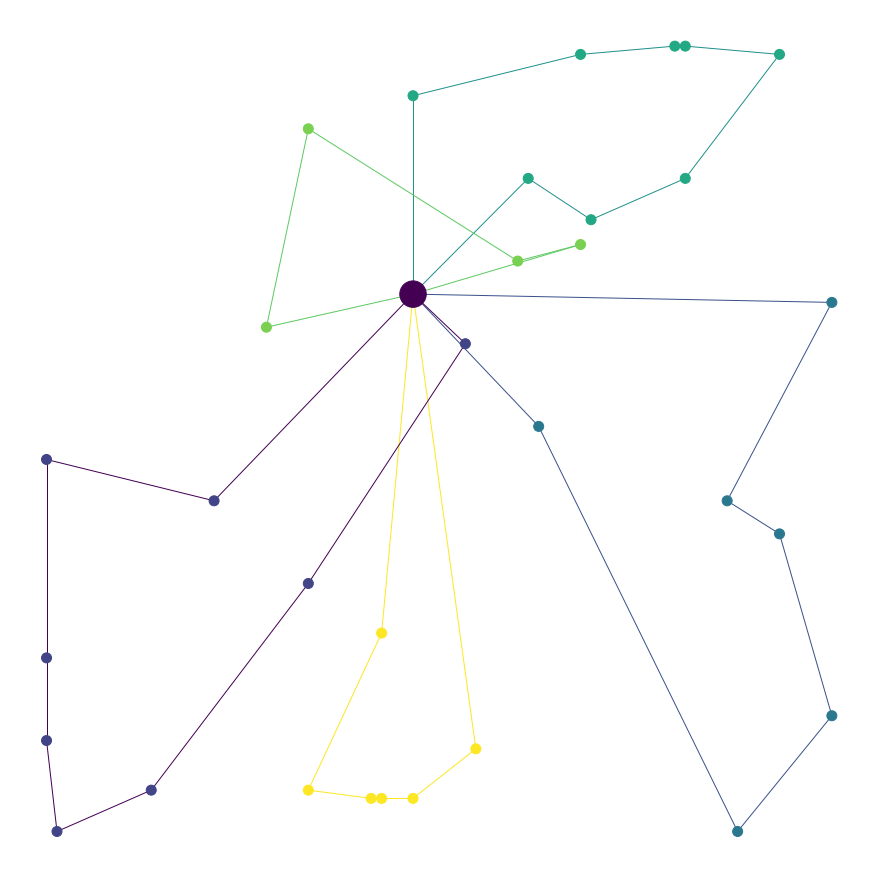

In [142]:
import networkx as nx

G = nx.Graph()
node_sizes = []
for index, row in dataframe.iterrows():
    G.add_node(row["numero_punto"],pos=(row["x"],row["y"]), color=row["caminos"])
    node_sizes.append(100)

node_sizes[0] = 700 # hago mas grande el depot (que es el primero)

c = int(results[0])
for i in range(c):
    camino = results[i+1]
    camino = camino.split()
    for j in range(1,len(camino)):
        G.add_edge(int(camino[j-1]), int(camino[j]), color=i)

pos=nx.get_node_attributes(G,'pos')

edges = G.edges()
nodes = G.nodes()
edge_colors = [G[u][v]['color'] for u,v in edges]

node_colors = []
for i in range(len(G)):
    node_colors.append(G.nodes[(i+1)]['color'])


plt.figure(1,figsize=(12,12)) 
nx.draw(G,pos, edge_color=edge_colors, node_size=node_sizes, node_color=node_colors)
plt.show()

# Graficar otra instancia

In [10]:
dataframe = calcular_y_graficar('X-n502-k39', ALGORITHM_FILENAME)
dataframe

,numero_punto,x,y,objetivo,truck_amount,vertex_amount,result,caminos
0,1,42,68,0,100,33,711,0
1,2,77,97,5,100,33,711,3
2,3,28,64,23,100,33,711,4
3,4,77,39,14,100,33,711,2
4,5,32,33,13,100,33,711,1
5,6,32,8,8,100,33,711,5
6,7,42,92,18,100,33,711,3
7,8,8,3,19,100,33,711,1
8,9,7,14,10,100,33,711,1
9,10,82,17,18,100,33,711,2
